In [1]:
# This can be used also as a script (created by uncommenting the following line in each cell)
#%%file 2021_07_23_script_nls_evolution.py
%matplotlib notebook
import numpy as np
from numpy.linalg import norm
import scipy as sp
import scipy.special
import scipy.sparse as scs
import scipy.sparse.linalg as scl
import scipy.integrate as integrate
from scipy.integrate import solve_bvp
import scipy.optimize as sco
from scipy import integrate
import time
from datetime import datetime
import sys
import shelve
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [2]:
#%%file --append 2021_07_23_script_nls_evolution.py
TeXFont = True
#plt.rcParams['figure.figsize']=[6,(3/4)*6]
if TeXFont:
    plt.rcParams['font.size'] = 14.0         # font size
    plt.rcParams['mathtext.fontset'] = 'cm'  # computer moder math font
    plt.rcParams['text.usetex'] = True       # use tex engine for everything (useful for the axes labels)
else:
    plt.rcParams['text.usetex'] = False

FontSize = 14

In the following cell, we introduce the discretization of the real line $\mathbb R$ as a finite number $N$ of points equally distributed between $-L$ and $L$ and we construct the discretized Laplacian matrix with Dirichlet boundary conditions.

In [3]:
#%%file --append 2021_07_23_script_nls_evolution.py

L=50 # half length of the interval on which we discretize
N=10000+1 # number of discretization points
#x,dx=np.linspace(-L, L, num=N, endpoint=False,retstep=True) # without right end point for periodic
x,dx=np.linspace(-L, L, num=N,retstep=True) # with right end point for Dirichlet

# construction of the Laplacian matrix with Dirichlet conditions
def Laplace(N,dx):
    main_diag = [-2 for i in range(N)]
    upper_diag= [1 for i in range(N-1)]
    lower_diag= upper_diag
    diagonals=[lower_diag,main_diag,upper_diag]
    Lap=scs.diags(diagonals,[-1,0,1])/dx**2
    return Lap
Lap=Laplace(N,dx)

Before simulating the evolution flow, we compute the critical omega associated with our parameters.

In [4]:
#%%file --append 2021_07_23_script_nls_evolution.py

def f1(z,p1,p2,a1=-1,a2=1):
    s=np.abs(z)
    return -a1*s**((p1-1)/2)-a2*s**((p2-1)/2)

def F1(z,p1,p2,a1=-1,a2=1):
    s=np.abs(z)
    return -(a1*s**((p1+1)/2))*2/(p1+1)-(a2*s**((p2+1)/2))*(2/(p2+1))

def U(s,w,p1,p2,a1=-1,a2=1):
    s=np.abs(s)
    return w*s+F1(s,p1,p2,a1,a2)

def U_der(s,w,p1,p2,a1=-1,a2=1):
    s=np.abs(s)
    return w+f1(s,p1,p2,a1,a2)

def U_div_s(s,w,p1,p2,a1=-1,a2=1):
    s=np.abs(s)
    return (w-(a1*s**((p1-1)/2))*2/(p1+1)-(a2*s**((p2-1)/2))*(2/(p2+1)))   

def U_div_s_prime(s,w,p1,p2,a1=-1,a2=1):
    s=np.abs(s)
    return -(a1*s**((p1-3)/2))*2/(p1+1)*(p1-1)/2-(a2*s**((p2-3)/2))*(2/(p2+1))*(p2-1)/2

def a(w,p1,p2,a1=-1,a2=1):
    a=sco.fsolve(U_div_s, 10,args=(w,p1,p2,a1,a2),fprime=U_div_s_prime,xtol=10**(-12))
    a=np.abs(a)
    if a==0:
        print("error in a , a is 0")
    return a

def J(w,p1,p2,a1=-1,a2=1):
    A=a(w,p1,p2,a1,a2)
    def integrand(s):
        C=-A**(1.5)/(2*U_der(A,w,p1,p2,a1,a2))
        I=(3+A*s*(U_der(A,w,p1,p2,a1,a2)-U_der(A*s,w,p1,p2,a1,a2))/U(A*s,w,p1,p2,a1,a2))*np.sqrt(s)/np.sqrt(np.abs(U(A*s,w,p1,p2,a1,a2)))
        return C*I
    I=integrate.quad(integrand, 0, 1,epsabs=10**(-100),limit=100)
    return I[0]

# construction of a function returning the critical omega

def w_critical(p1,p2,a1=-1,a2=1):
    dp1=0.0001
    dp2=0.0001
    if ((p2<=p1+dp1/2) or (p2-dp2/2<(-2*p1+7))):
        return 0
    else:
        try:
            precision=1
            tol=0.00001
            w1,w2=0,1           
            while J(w2,p1,p2,a1,a2)<0:
                w2=2*w2
                if w2>10**(10):
                    w1=10**(10)
                    break                   
            while precision>tol:
                w_tmp=w1+(w2-w1)/2
                if J(w_tmp,p1,p2,a1,a2)>0:
                    w2=w_tmp
                else:
                    w1=w_tmp
                precision=(w2-w1)/w2
                if w2<10**(-12):
                    break
        except:
            pass
    return w1


To perform the numerical simulations, it might be helpful to restrict ourselves to the case $q=2p-1$, for which we have explicit formulas for the standing waves (as given in the next cell). 

In [5]:
#%%file --append 2021_07_23_script_nls_evolution.py

def profile_explicit(x,beta,w=1,a1=-1,a2=1):
    # Explicit standing wave profile 
    # for double power nonlinearities of the form p1=1+1/beta,p2=1+2/beta
    # in such a way that p2=2p1-1
    # See 234nls-v218.pdf page 36
    A=a1/(2+1/beta)
    B=a2/(1+1/beta)
    return (w/(A+np.sqrt(A**2+B*w)*np.cosh(beta**(-1)*np.sqrt(w)*x)))**beta

<center> <h1> "scipy.integrate.solve_bvp" Solve a boundary value problem for a system of ODEs. </h1> </center>
This function numerically solves a first order system of ODEs subject to two-point boundary conditions.

Our system is 
\begin{cases}
y_1'  &=y_2 \\
y_2' &=\omega y_1-a_p|y_1|^{p-1}y_1-a_q|y_1|^{q-1}y_1
\end{cases}

with the boundary conditions $\phi(0)= initialvalue(\phi) , \quad \phi(L)=0.$

In [6]:
#%%file --append 2021_07_23_script_nls_evolution.py

def initialvalue(phi,p1,p2,w=1,a1=-1,a2=1):
    return (a1/(p1+1)*phi**(p1-1)+a2/(p2+1)*phi**(p2-1)-w/2)

def fun(x, y,p1,p2,w=1,a1=-1,a2=1):
    return np.vstack((y[1], w*y[0]-a1*np.abs(y[0])**(p1-1)*y[0]-a2*np.abs(y[0])**(p2-1)*y[0]))

def bc(ya, yb,p1,p2,w=1,a1=-1,a2=1):
    partial_initialvalue = partial(initialvalue, p1=p1,p2=p2,w=w,a1=a1,a2=a2)
    return [ya[0]-sco.fsolve(partial_initialvalue,1), yb[0]]

def profile(x,p1,p2,w=1,a1=-1,a2=1):
    # if p2=2p1-1, we use the explicit formula
    if np.abs(p2-2*p1+1)<1e-14:
        beta=1/(p1-1)
        return profile_explicit(x,beta,w,a1,a2)
    # else, we compute with the solve_bvp method
    # not working well for larger w (above 2 or 3 ?)
    else:
        N=len(x)
        partial_initialvalue = partial(initialvalue, p1=p1,p2=p2,w=w,a1=a1,a2=a2)
        partial_fun = partial(fun, p1=p1,p2=p2,w=w,a1=a1,a2=a2)
        partial_bc = partial(bc, p1=p1,p2=p2,w=w,a1=a1,a2=a2)
        y_init =[1/(np.cosh(x)),np.tanh(x)/(np.cosh(x))]*sco.fsolve(partial_initialvalue,1)
        sol = solve_bvp(partial_fun, partial_bc, x, y_init,tol=0.00001,max_nodes=N)
        # to get the right solution, we even it
        even_sol_left=sol.y[0][int((N-1)/2):]
        even_sol_right=sol.y[0][int((N+1)/2):]
        even_sol=np.concatenate([even_sol_right[::-1],even_sol_left])
        return even_sol

In [7]:
#%%file --append 2021_07_23_script_nls_evolution.py

def initial_data(x,p1,p2,w=1,c=0,a1=-1,a2=1,init=0):
    # return a soliton profile with frequency w and speed c, 
    # modified according to the following rule:
    # init=0 -> no modification
    # init=1 -> profile multiplied by 1.01
    # init=2 -> profile multiplied by 0.99
    # init=3 -> profile multiplied by randn(x)*0.01
    # init=4 -> profile multiplied by 1+cos(x)*0.01
    # init=5 -> profile multiplied by 1+sin(x)*0.01
    # init=6 -> profile multiplied by 1+sech(x)*0.01
    # init=7 -> profile multiplied by 1+tanh(x)*0.01
    # init=8 -> profile multiplied by 1+sech(x-1)*0.01 
    if init==0:
        return profile(x,p1,p2,w,a1,a2)
    elif init==1:
        return profile(x,p1,p2,w,a1,a2)*1.01
    elif init==2:
        return profile(x,p1,p2,w,a1,a2)*0.99
    elif init==3:
        return profile(x,p1,p2,w,a1,a2)*(np.ones_like(x)+np.random.randn(np.shape(x)[0])*0.01)
    elif init==4:
        return profile(x,p1,p2,w,a1,a2)*(np.ones_like(x)+np.cos(x)*0.01)
    elif init==5:
        return profile(x,p1,p2,w,a1,a2)*(np.ones_like(x)+np.sin(x)*0.01)
    elif init==6:
        return profile(x,p1,p2,w,a1,a2)*(np.ones_like(x)+1/np.cosh(x)*0.01)
    elif init==7:
        return profile(x,p1,p2,w,a1,a2)*(np.ones_like(x)+np.tanh(x)*0.01)
    elif init==8:
        shift=np.argmax(x>1)-len(x)//2
        x_shifted=np.roll(x, shift)
    return profile(x,p1,p2,w,a1,a2)*(np.ones_like(x)+1/np.cosh(x_shifted)*0.01)

In the next cell, we implement a Crank-Nicolson scheme with relaxation. 

In [8]:
#%%file --append 2021_07_23_script_nls_evolution.py

# Numerical simulation of NLS with Crank-Nicolson scheme with relaxation (see Besse 2004)
# SIAM Journal on Numerical Analysis, 2004, Vol. 42, No. 3 : pp. 934-952
# A Relaxation Scheme for the Nonlinear Schrödinger Equation
# Christophe Besse
# https://doi.org/10.1137/S0036142901396521

def nls(x,p1,p2,T=1,delta_t = 1e-3,w=1,c=0,a1=-1,a2=1,init=0):
    # Warning: output is trimmed so that only approximately 100 values in x and in t are kept.
    # Use next cell for full output
    Id=scs.identity(N)
    M_1 = Id - 1j*delta_t/2*Lap
    psi=initial_data(x,p1,p2,w,c,a1,a2,init)
    # u_t_x stores the values of psi troncated in such a way that a bit more than 100 values of x and t are taken into account
    N_x=len(x)
    psi_tmp=psi[N_x//4:3*N_x//4]
    u_t_x=psi_tmp[::len(psi_tmp)//100]
    #initialisation step
    phi = -(a1*np.abs(psi)**(p1-1)+a2*np.abs(psi)**(p2-1))
    nb_iter=int(T//delta_t)
    iter_save_step=nb_iter//100
    y_size_u_t_x=1
    max_u_t_x=np.max(np.abs(psi))
    for n in range(nb_iter):
        phi = -2*(a1*np.abs(psi)**(p1-1)+a2*np.abs(psi)**(p2-1)) - phi
        M = M_1 + 1j*delta_t/2*scs.diags(phi)
        varphi = scl.spsolve(M,psi)
        psi = 2*varphi - psi
        max_u_t_x = np.append(max_u_t_x,np.max(np.abs(psi)))
        if n%iter_save_step==0:
            print(f'iteration {n+1} over {nb_iter}',end='\r')
            psi_tmp=psi[N_x//4:3*N_x//4]
            u_t_x=np.append(u_t_x,psi_tmp[::len(psi_tmp)//100])
            y_size_u_t_x=y_size_u_t_x+1
    u_t_x=np.reshape(u_t_x,(y_size_u_t_x,-1))
    u_t_x=u_t_x.T
    return u_t_x,max_u_t_x

In [9]:
#%%file --append 2021_07_23_script_nls_evolution.py

def make_pdf_figure(u_t_x,x,p1,p2,T=1,delta_t = 1e-3,w=1,w_c=float("nan"),c=0,a1=-1,a2=1,init=0):
    N_x=len(x)
    x_clip=x[N_x//4:3*N_x//4]
    x_clip=x_clip[::len(x_clip)//100]
    nb_x_clip,nb_iter_clip=np.shape(u_t_x)
    Tt_clip=np.linspace(0,T,nb_iter_clip)
    u_t_x_clip=np.abs(u_t_x)
    fig = plt.figure()
    fig.suptitle(rf"$a_p={a1}$, $a_q={a2}$, $p={p1:.2f}$, $q={p2:.2f}$, $\omega={w:.2f}$, $\omega_c={w_c:.2f}$, init=${init}$")
    ax = fig.add_subplot(111, projection='3d')
    X, TT = np.meshgrid(x_clip,Tt_clip)
    ax.plot_surface(X,TT,u_t_x_clip.T)
    ax.set_xlabel(r"$x$",fontsize=FontSize)
    ax.set_ylabel(r"$t$",fontsize=FontSize)
    ax.set_zlabel(r"$|u(t,x)|$",fontsize=FontSize)
    ax.xaxis.set_rotate_label(False)  # disable automatic rotation
    ax.yaxis.set_rotate_label(False)  # disable automatic rotation
    #ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    fig.savefig(f"nls_evol_a1_is_{a1}_a2_is_{a2}_p1_is_{p1:.2f}_p2_is_{p2:.2f}_w_is_{w:.2f}_w_c_is_{w_c:.2f}_init_is_{init}.pdf",transparent=True,orientation='landscape',format='pdf',bbox_inches='tight')
    

In [10]:
#%%file --append 2021_07_23_script_nls_evolution.py

def make_html_figure(u_t_x,x,p1,p2,T=1,delta_t = 1e-3,w=1,w_c="nc",c=0,a1=-1,a2=1,init=0):
    N_x=len(x)
    x_clip=x[N_x//4:3*N_x//4]
    x_clip=x_clip[::len(x_clip)//100]
    nb_x_clip,nb_iter_clip=np.shape(u_t_x)
    Tt_clip=np.linspace(0,T,nb_iter_clip)
    u_t_x_clip=np.abs(u_t_x.T)
    fig = go.Figure(data=[go.Surface(z=u_t_x_clip, x=x_clip, y=Tt_clip)])
    fig.update_layout(  title=f'a1={a1}, a2={a2}, p1={p1:.2f}, p2={p2:.2f}, w={w:.2f}, w_c={w_c:.2f}, init={init}',
                    scene = dict(
                    xaxis_title=r"space x",
                    yaxis_title='time t',
                    zaxis_title='|u(t,x)|'))
    # known limitation : latex cannot be displayed in axis title
    fig.show()
    fig.write_html(f"nls_evol_a1_is_{a1}_a2_is_{a2}_p1_is_{p1:.2f}_p2_is_{p2:.2f}_w_is_{w:.2f}_w_c_is_{w_c:.2f}_init_is_{init}.html")
    #https://plotly.com/python/3d-surface-plots/ 

In [11]:
#%%file --append 2021_07_23_script_nls_evolution.py

def make_max_figure(max_u_t_x,p1,p2,T=1,delta_t = 1e-3,w=1,w_c=float("nan"),c=0,a1=-1,a2=1,init=0):
    N_t=len(max_u_t_x)
    Tt=np.linspace(0,T,N_t)
    fig = plt.figure(figsize=(8,6))
    fig.suptitle(f"Plot of $t\mapsto\max|u(t,x)|$ when\n$a_p={a1}$, $a_q={a2}$, $p={p1:.2f}$, $q={p2:.2f}$, $\omega={w:.2f}$, $\omega_c={w_c:.2f}$, init=${init}$")
    ax = fig.add_subplot(111)
    ax.plot(Tt,max_u_t_x)
    ax.set_xlabel(r"$t$",fontsize=FontSize)
    ax.set_ylabel(r"$|u(t,x)|$",fontsize=FontSize)
    fig.savefig(f"nls_max_a1_is_{a1}_a2_is_{a2}_p1_is_{p1:.2f}_p2_is_{p2:.2f}_w_is_{w:.2f}_w_c_is_{w_c:.2f}_init_is_{init}.pdf",transparent=True,orientation='landscape',format='pdf',bbox_inches='tight')

In [12]:
#%%file --append 2021_07_23_script_nls_evolution.py

def variables_backup(u_t_x,max_u_t_x,x,p1,p2,T=1,delta_t = 1e-3,w=1,w_c="nc",c=0,a1=-1,a2=1,init=0):
    # Save all variables (with in particular w_critical) to file with date in file name    
    filename=f"nls_var_bckup_a1_is_{a1}_a2_is_{a2}_p1_is_{p1:.2f}_p2_is_{p2:.2f}_w_is_{w:.2f}_w_c_is_{w_c:.2f}_init_is_{init}.npy"
    with open(filename, 'wb') as f:
        np.save(f, T)
        np.save(f, a1)
        np.save(f, a2)
        np.save(f, p1)
        np.save(f, p2)
        np.save(f, c)
        np.save(f, delta_t)
        np.save(f, init)
        np.save(f, w)
        np.save(f, w_c)
        np.save(f, x)
        np.save(f, u_t_x)
        np.save(f, max_u_t_x)
        
# to reload the variables :
#with open(filename, 'rb') as f:
#    T = np.load(f)
#    a1 = np.load(f)
#    a2 = np.load(f)
#    p1 = np.load(f)
#    p2 = np.load(f)
#    c = np.load(f)
#    delta_t = np.load(f)
#    init = np.load(f)
#    w = np.load(f)
#    w_c = np.load(f)
#    x = np.load(f)
#    u_t_x = np.load(f)

 

In [13]:
#%%file --append 2021_07_23_script_nls_evolution.py

def nls_evolution_process(p1,p2,w,init):    
    T=40
    delta_t=1e-3    
    c=0
    a1=0
    a2=1    
    try:
        u_t_x,max_u_t_x=nls(x,p1,p2,T,delta_t,w,c,a1,a2,init)
        w_c=w_critical(p1,p2,a1,a2) 
        make_html_figure(u_t_x,x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)
        make_pdf_figure(u_t_x,x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)
        make_max_figure(max_u_t_x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)
        variables_backup(u_t_x,max_u_t_x,x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)
    except Exception as e:
        print(f"we have a problem with p1={p1}, p2={p2}, w={w}, init={init}")
        print(e)

<ipython-input-4-bb9fee59fe9d>:40: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I=integrate.quad(integrand, 0, 1,epsabs=10**(-100),limit=100)


<IPython.core.display.Javascript object>


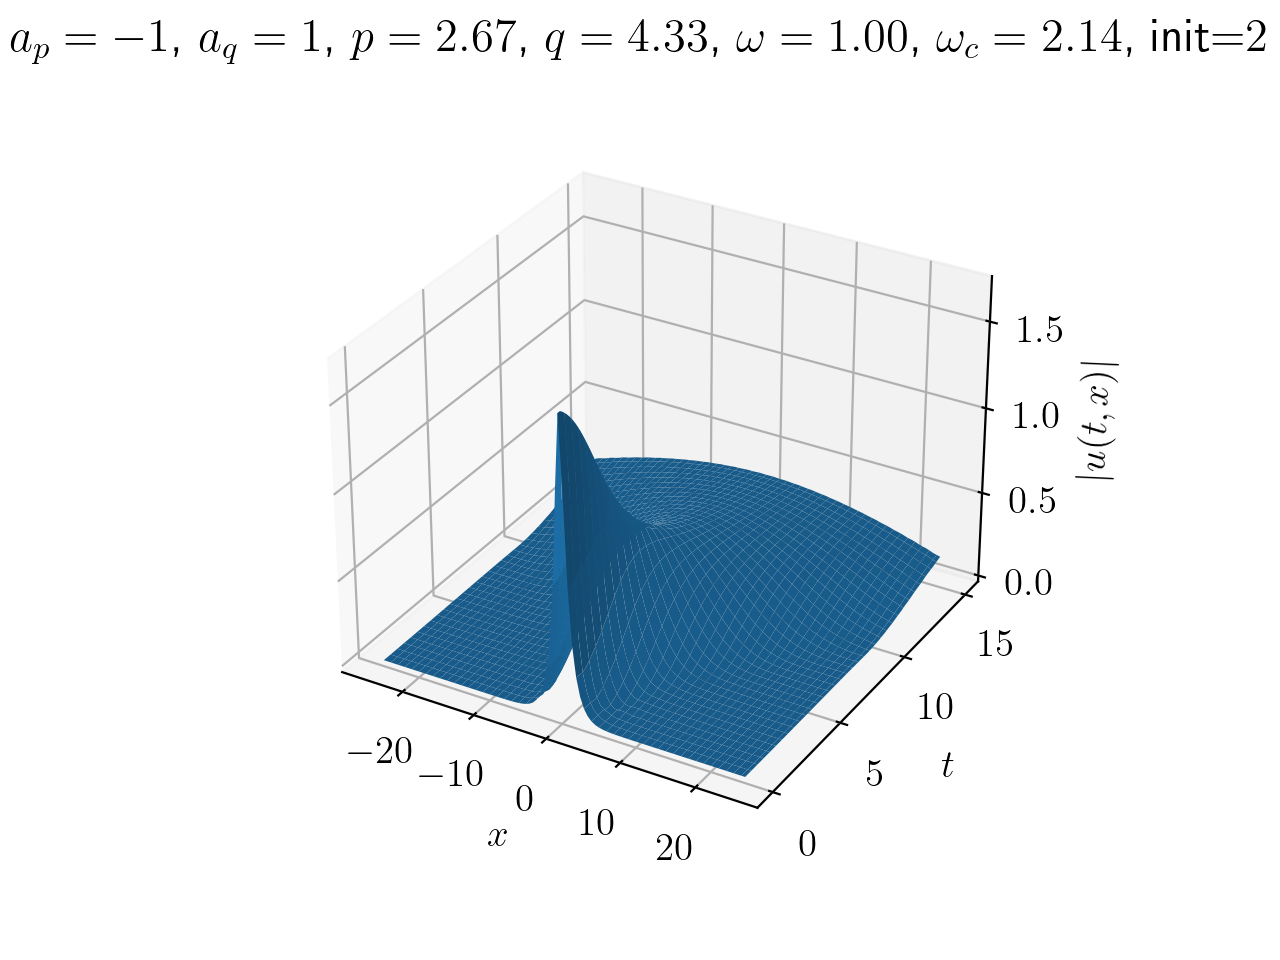

<IPython.core.display.Javascript object>


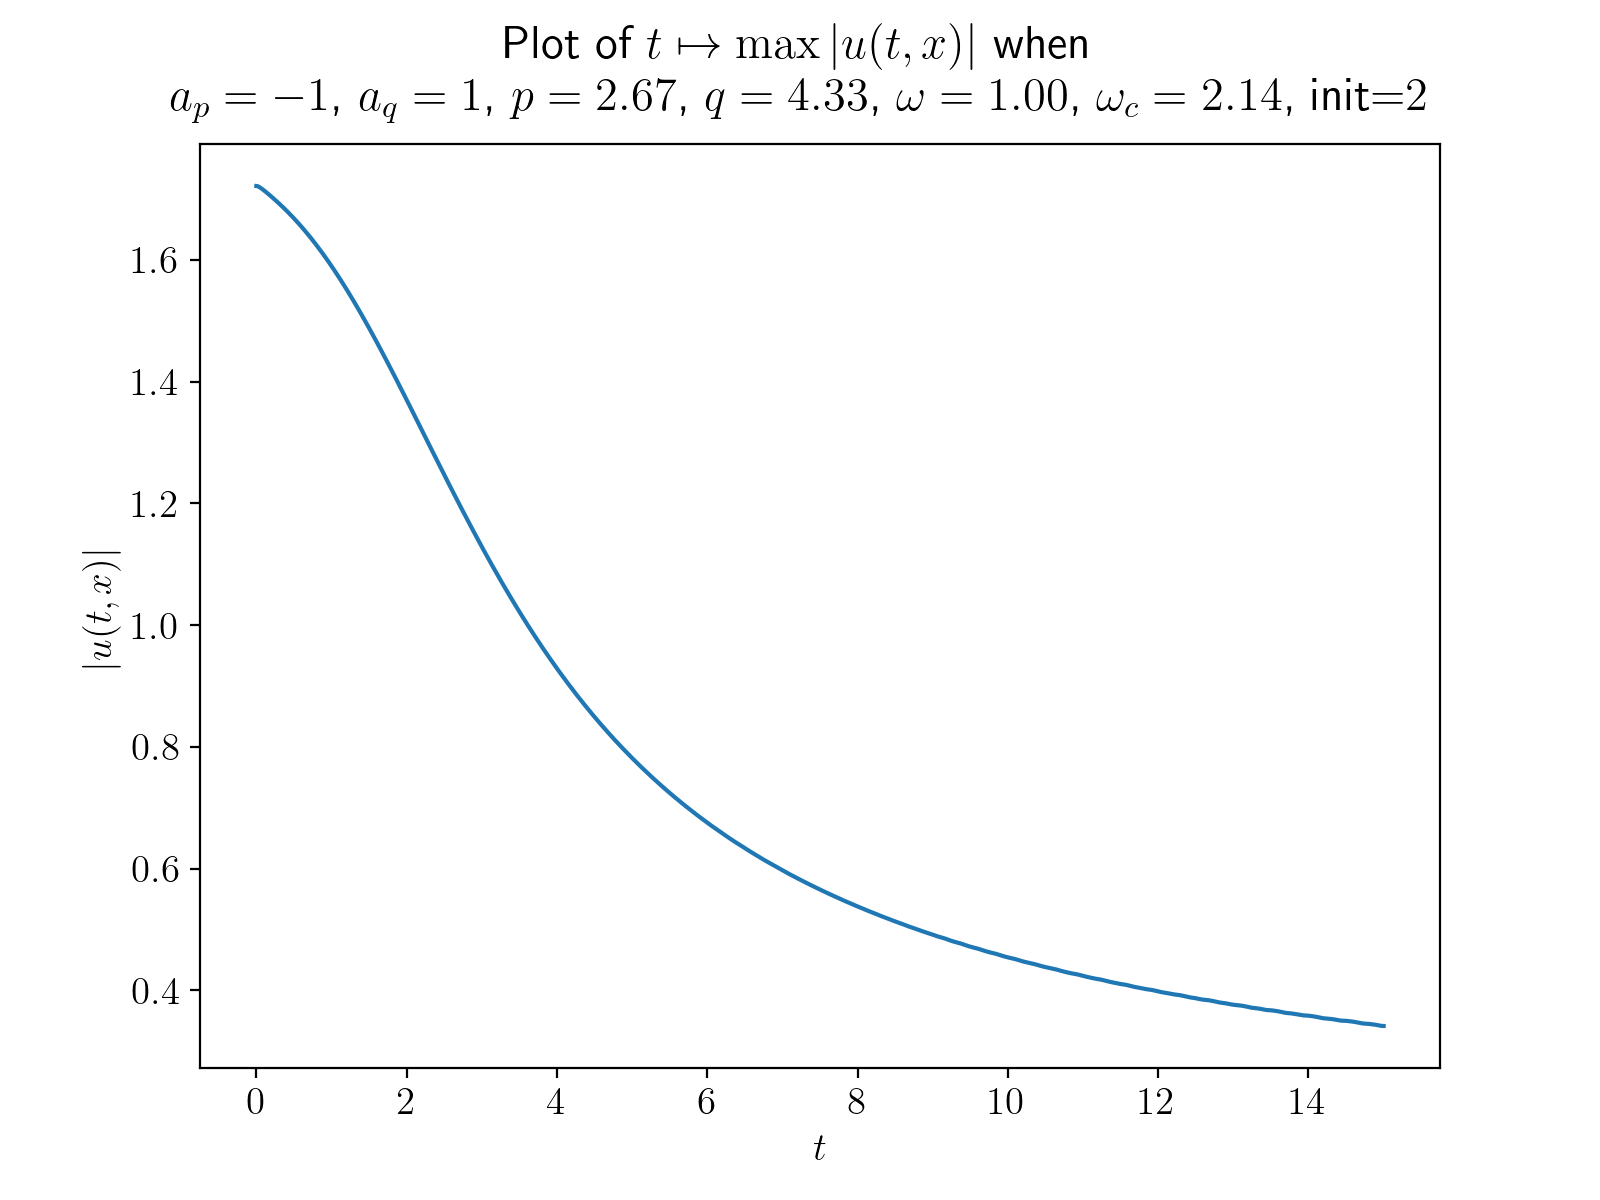

In [14]:
# Cell for simulations one by one
plt.close()
#beta=5/8
beta=0.6
p1=1+1/beta
p2=1+2/beta
#p1=2
#p2=4
w=1
init=2
T=15
delta_t=1e-3    
c=0,
a1=-1
a2=1    
u_t_x,max_u_t_x=nls(x,p1,p2,T,delta_t,w,c,a1,a2,init)
w_c=w_critical(p1,p2)
#make_html_figure(u_t_x,x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)
make_pdf_figure(u_t_x,x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)
make_max_figure(max_u_t_x,p1,p2,T,delta_t,w,w_c,c,a1,a2,init)